# Méthode des sinus carré psi

pic par pic sur l'ARB 16nm

In [104]:
import numpy as np
import matplotlib.pylab as plt

import glob
import re

In [141]:
#import sys
#sys.path.append('../theta_2theta/')
#from fit_peak import fit_peak

In [142]:
def peak_Gauss(x, position, fwhm, amplitude,
               base_height, base_slope):
    amplitude = amplitude * 2/fwhm * np.sqrt(np.log(2)/np.pi)
    gauss = np.exp(-4*np.log(2)/fwhm**2 * (x-position)**2 )
    base_line = base_height + base_slope * x
    return amplitude*gauss + base_line

def peak_Lorentzien(x, position, fwhm, amplitude, base_height, base_slope):
    base_line = base_height + base_slope * x
    return 2*amplitude/np.pi/fwhm/(1 + 4*(np.sqrt(2)-1)/fwhm**2*(x-position)**2) + base_line

def peak_pseudoVoigt(x, position, fwhm, amplitude, base_height, base_slope, eta):
    return (1-eta)*peak_Gauss(x, position, fwhm, amplitude, base_height, base_slope) + \
           eta*peak_Lorentzien(x, position, fwhm, amplitude, 0, 0)


def fit_peak(x, y, function='pseudoVoigt'):
    ''' Fit a peak function on the given x, y data
        function 'Lorentz', 'pseudoVoigt' or 'Gauss'
        
        Returns:
            center position
            FWHM
            peak(x): function of the fitted peak 
    '''
    x, y = np.asarray(x), np.asarray(y)

    p0 = [x[np.argmax(y)], # center
          x[y>(y.min()+y.ptp()/2)].ptp(), # estimated width
          y.ptp(), # amplitude, peak to peak, i.e. max - min
          y.min(), # base height
          0]       # base slope

    if function == 'Lorentz':
        popt, pcov = curve_fit(peak_Lorentzien, x, y, p0=p0)
        #plt.plot(x, peak_Lorentzien(x, *popt), 'r');
        fitted_function = lambda u: peak_Lorentzien(u, *popt)
        FWHM = 2*popt[1]
        
    elif function == 'pseudoVoigt':
        p0.append(0.5) # eta
        popt, pcov = curve_fit(peak_pseudoVoigt, x, y, p0=p0)
        fitted_function = lambda u: peak_pseudoVoigt(u, *popt)
        FWHM = 2*popt[1] # no!!
        
    else: # Gauss
        popt, pcov = curve_fit(peak_Gauss, x, y, p0=p0)
        #plt.plot(x, peak_Gauss(x, *popt), 'r');
        fitted_function = lambda u: peak_Gauss(u, *popt)
        FWHM = 2*np.sqrt(2*np.log(2))*popt[1]
    
    
    return popt[0], np.abs(FWHM), fitted_function

In [132]:
''' CSV Tools
'''

def read_csv(path):
    skip_header = 34
    data = np.genfromtxt(path,
                         skip_header=skip_header,
                         delimiter=',')
    data_dico = dict()
    data_dico['deuxtheta'] = data[:, 0]
    data_dico['I'] = data[:, 1]
    return data_dico


def get_field(csv, fieldname):
    '''Extract information form the csv file (string) for the asked fieldname'''
    line = next(line for line in csv if line.startswith(fieldname))
    
    line = line.strip().split(',')[1:]
    
    if len(line) == 1:
        return float(line[0])
    else:
        return line


class Measure():

    def __init__(self, path):
        self.path = path
        
        m = read_csv(path)
        self.deuxtheta = m['deuxtheta']
        self.I = m['I']
        
        self.fit(plot=False)
        
        # Extract measurement info
        with open(path, 'r') as f:
            csv = f.readlines()
            self.phi = get_field(csv, 'Phi')
            self.psi = phi = get_field(csv, 'Psi')
            
        # Extract measurement name
        name = path.split('/')[-1]
        words_to_remove = ['moved', '.csv', '2theta_omega']
        for word in words_to_remove:
            name = name.replace(word, '').strip('._')
        self.name = name
        
        # Extract hkl values
        hkl_pattern = '(-?\d)(-?\d)(-?\d)'
        self.hkl = [int(i) for i in re.findall(hkl_pattern, self.name)[0]]
        
        self.d_hkl_theo = distance_from_hkl(self.hkl, 'Cu' if 'Cu' in self.name else 'Nb')
        
    def plot(self):
        plt.plot(self.deuxtheta, self.I, label=self.name);
        plt.xlabel('deux theta (deg)');
        plt.ylabel('I');
        plt.title(self.name)
        
        
    def fit(self, plot=True, function='pseudoVoigt'):
        
        try:
            x0, fwhm, fitfunction = fit_peak(self.deuxtheta, self.I,
                                      function=function)
            self.successful_fit = True
        except RuntimeError:
            x0, fwhm, fitfunction = np.NaN, np.NaN, lambda x:np.zeros_like(x)
            self.successful_fit = False
            
        self.x0 = x0
        self.fwhm = fwhm
        self.fitfunction = fitfunction
        
        self.d_fit = distance_from_Bragg(x0)
        
        if plot:
            ax1 = plt.subplot(2, 1, 1);
            self.plot();
            plt.legend();

            plt.plot(self.deuxtheta, self.fitfunction(self.deuxtheta), 'r', alpha=0.5)
            plt.plot(self.x0, self.fitfunction(self.x0), 'or', alpha=0.5);
            
            deuxtheta_theo = (self.deuxtheta[0]+self.deuxtheta[-1])/2
            plt.axvline(x=deuxtheta_theo)
            
            # residue
            plt.subplot(2, 1, 2, sharex=ax1);
            plt.axhline(y=0, linewidth=1, color='black')
            plt.plot(self.deuxtheta, self.I-self.fitfunction(self.deuxtheta), 'r', alpha=0.5)
            

In [133]:
''' The Bragg's law
'''
lmbda = 1.5405929 # Ang., x-ray wavelength   K_alpha1 Cu

lattice_param = {}
lattice_param['Cu'] = 3.615  # Ang.
lattice_param['Nb'] = 3.3063 # Ang.

def distance_from_Bragg(deux_theta):
    ''' deux_theta in degrees, d in Angstöm '''
    deux_theta = np.asarray(deux_theta)
    return lmbda/2/np.sin(deux_theta/2 *np.pi/180)

def distance_from_hkl(hkl, mat):
    hkl = np.asarray(hkl)
    return lattice_param[mat]/np.sqrt(np.sum(hkl**2))

In [134]:
''' Load the files
'''

dirname = './arb16nm_pip_par_pic/'

filelist = glob.glob(dirname + '*.csv')
print(filelist)

data = [Measure(path) for path in filelist]

['./arb16nm_pip_par_pic/2theta_omega_Nb-123.csv', './arb16nm_pip_par_pic/2theta_omega_Cu1-13.csv', './arb16nm_pip_par_pic/2theta_omega_Nb-1-12.csv', './arb16nm_pip_par_pic/2theta_omega_Nb123.csv', './arb16nm_pip_par_pic/2theta_omega_Cu-202.csv', './arb16nm_pip_par_pic/2theta_omega_Nb-121.csv', './arb16nm_pip_par_pic/2theta_omega_Cu113.csv', './arb16nm_pip_par_pic/2theta_omega_Nb020.csv', './arb16nm_pip_par_pic/2theta_omega_Cu111.csv', './arb16nm_pip_par_pic/2theta_omega_Cu002.csv', './arb16nm_pip_par_pic/2theta_omega_Cu13-1.csv', './arb16nm_pip_par_pic/2theta_omega_Nb-112.csv', './arb16nm_pip_par_pic/2theta_omega_Cu202.csv', './arb16nm_pip_par_pic/2theta_omega_Nb011.csv', './arb16nm_pip_par_pic/2theta_omega_Cu31-1.csv', './arb16nm_pip_par_pic/2theta_omega_Nb132.csv', './arb16nm_pip_par_pic/2theta_omega_Cu022.csv', './arb16nm_pip_par_pic/2theta_omega_Cu200.csv', './arb16nm_pip_par_pic/2theta_omega_Nb1-23.csv', './arb16nm_pip_par_pic/2theta_omega_Cu-113.csv', './arb16nm_pip_par_pic/2thet

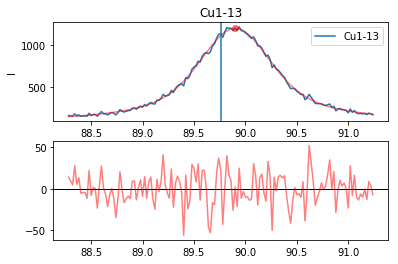

In [135]:
m = Measure(filelist[1])
m.fit(plot=True)

/home/etiennenavarro/notebooks/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


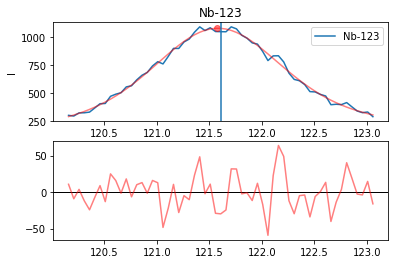

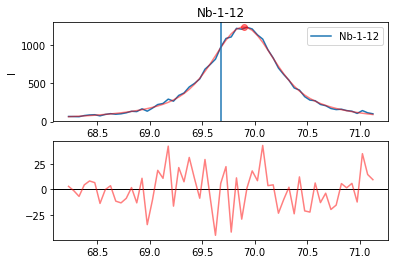

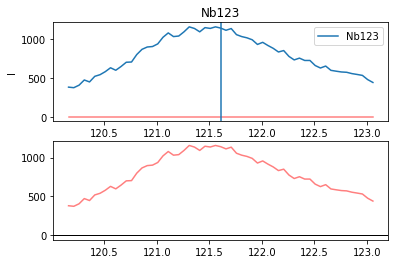

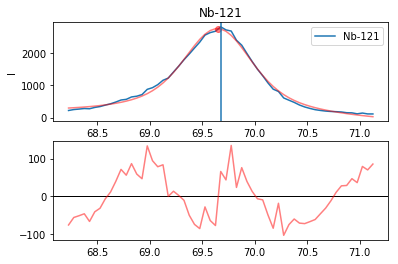

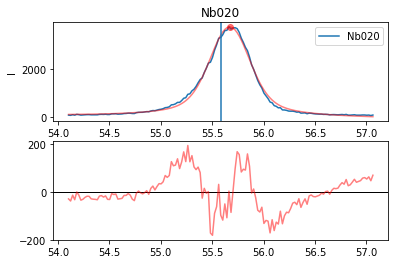

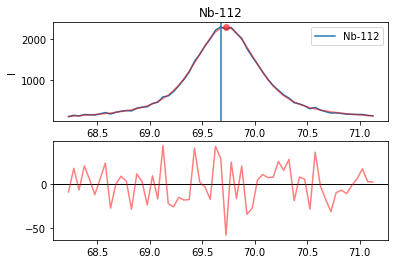

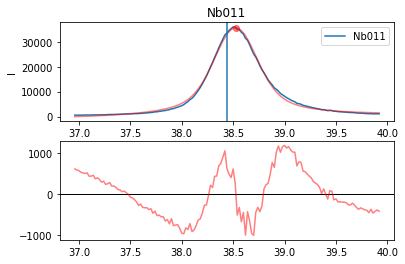

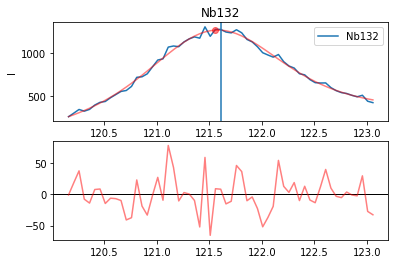

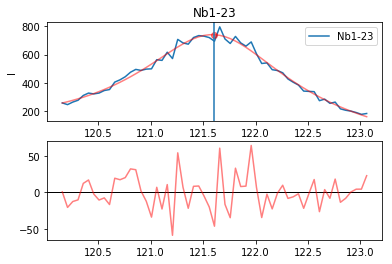

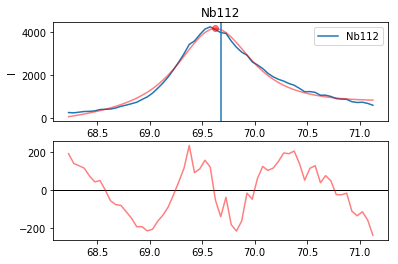

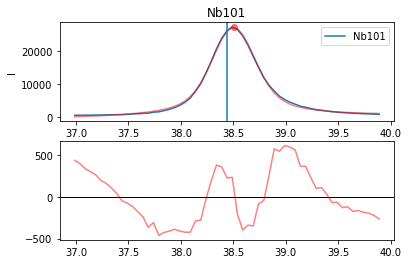

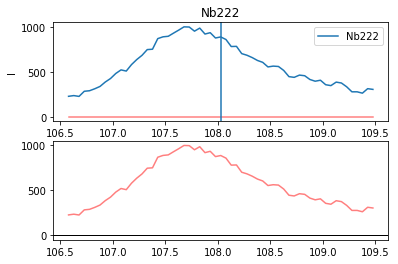

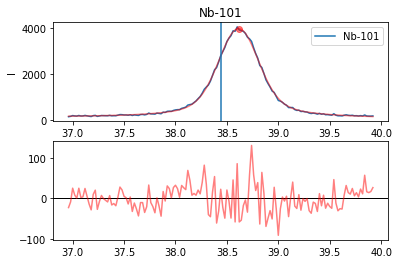

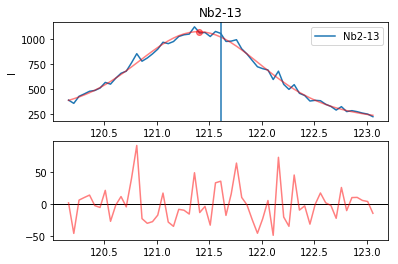

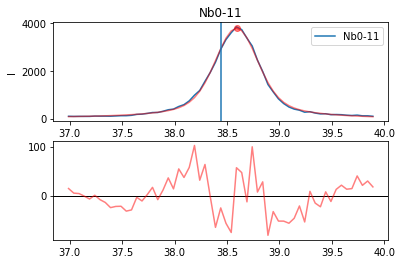

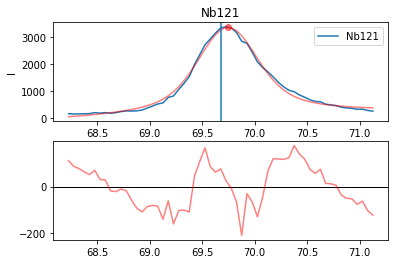

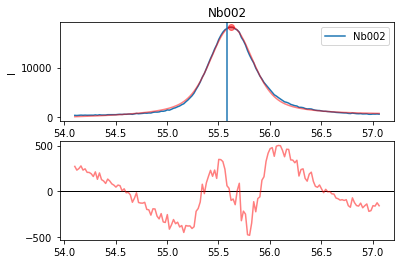

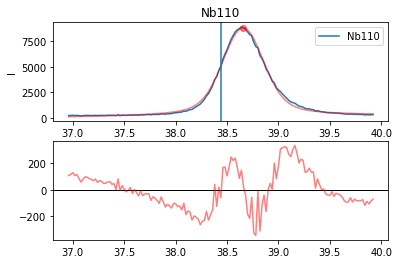

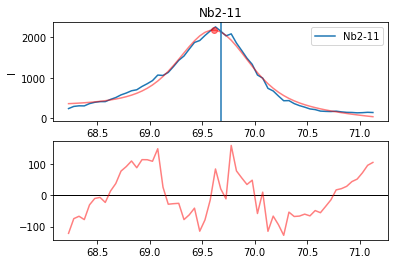

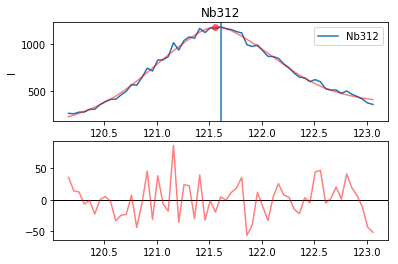

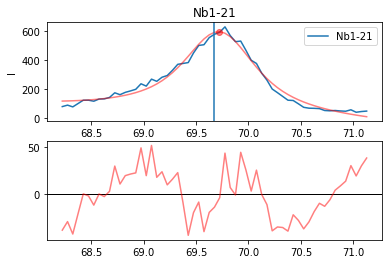

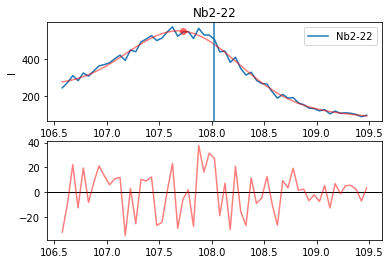

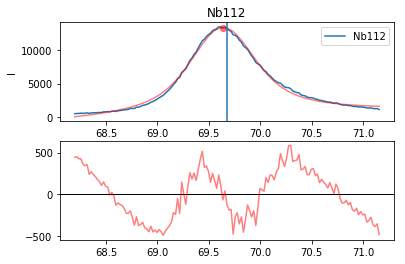

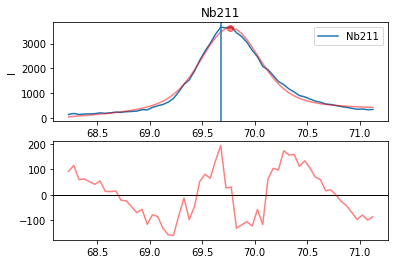

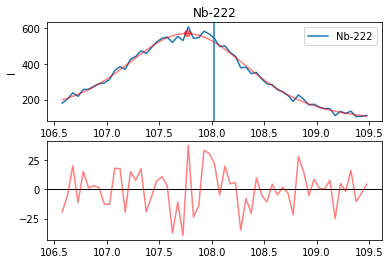

In [123]:
for m in data:
    if 'Nb' in m.name:
        plt.figure();
        m.fit(plot=True)

*note:* Cu peaks are more symetric than Nb peaks

# sinus carré psi equation
![equation](./eq5.4_sin2psi_strainTensor_Nohan.png)

--> Regression lineaire

hypotheses:
- monocrystal
    - isotropic
    - non isotropic
  
- d0 from theo
- d0 from fit(?)

In [140]:
material = 'Nb'
phi_psi_eps33 = [(m.phi, m.psi, (m.d_fit-m.d_hkl_theo)/m.d_hkl_theo)
                 for m in data if material in m.name and m.successful_fit]

phi_psi_eps33 = list(zip(*phi_psi_eps33))

phi, psi, eps33 = [np.asarray(u) for u in phi_psi_eps33]


phi_rad = phi *np.pi/180
psi_rad = psi *np.pi/180

M = np.vstack([np.cos(phi)**2 * np.sin(psi)**2, # *eps_11
               np.sin(2*phi) * np.sin(psi)**2, # *eps_12
               np.sin(phi)**2 * np.sin(psi)**2, # *eps_22
               np.cos(psi)**2, # *eps_33
               np.cos(phi) * np.sin(2*psi), # *eps_13
               np.sin(phi) * np.sin(2*psi)]) # *eps_23

# M * eps = eps33
eps_ij, sum_sq_residuals, _, _ = np.linalg.lstsq(M.T, eps33, rcond=None)

C = np.linalg.inv( np.matmul(M, M.T) )
Cii = np.diag(C)

errors = np.sqrt( Cii*sum_sq_residuals/(len(phi) - 6) )*100

print('mat:' + material)
ij_list = [11, 12, 22, 33, 13, 23]
print('\n'.join([f'eps{ij}: {e*100: .2f}% +- {error:.3}%' for e, ij, error in zip(eps_ij, ij_list, errors)]))
# Cu: [ 0.2970988   0.14361518 -0.50973961 -0.01637047 -0.24344236  0.16554348]

# Nb: [-0.37692518 -0.14090128 -0.39825735 -0.11095182 -0.14484269 -0.03611807]

mat:Nb
eps11: -0.20% +- 0.0712%
eps12: -0.09% +- 0.0636%
eps22: -0.25% +- 0.0655%
eps33: -0.13% +- 0.0346%
eps13: -0.07% +- 0.0354%
eps23: -0.10% +- 0.0368%


    mat:Cu   sqrt(res**2)=array([0.24748743])
    eps11:  0.30%
    eps12:  0.14%
    eps22: -0.51%
    eps33: -0.02%
    eps13: -0.24%
    eps23:  0.17%
    
    mat:Nb
    eps11: -0.38%
    eps12: -0.14%
    eps22: -0.40%
    eps33: -0.11%
    eps13: -0.14%
    eps23: -0.04%

In [139]:
len(phi)

21

In [95]:
C = np.linalg.inv( np.matmul(M, M.T) )

Cii = np.diag(C)

np.sqrt( Cii*sum_sq_residuals/(len(phi) - 6) )*100

In [74]:
np.sqrt( sum_sq_residuals )*100

array([0.24748743])

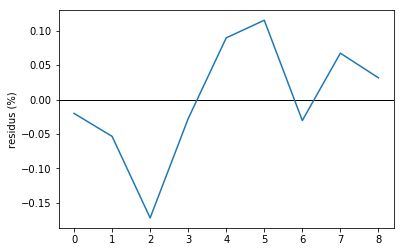

In [75]:
residus = np.matmul(M.T, eps_ij) - eps33

plt.axhline(y=0, linewidth=1, color='black')
plt.plot(residus*100);
plt.ylabel('residus (%)');

see page 421 Montgomery
$$
\sigma^2 = \frac{1}{n-p} \sum_i e_i^2
$$

In [78]:
np.std(residus)*100

0.0824958090530024

In [82]:
len(phi)

9

In [85]:
np.sqrt( np.sum(residus**2)/(len(phi) - 6) )*100

0.1428869326913007

In [27]:
import texttable as tt

In [28]:
table = tt.Texttable()

#table.set_cols_align(["l", "r", "r", "r", "l"])

table.header(['', 'phi', 'psi', 'd_fit [A]', 'd0', 'eps(%)'])
table.add_rows([[m.name, m.phi, m.psi, m.d_fit, m.d_hkl_theo, (m.d_fit-m.d_hkl_theo)/m.d_hkl_theo*100]
                for m in data],
               header=False)
    
table.set_deco(tt.Texttable.HEADER)
print( table.draw() )

         phi   psi   d_fit [A]    d0     eps(%)
Cu1-13   51    42    1.090       1.090   0.031 
Cu113    90    10    1.091       1.090   0.140 
Nb020    131   71    1.650       1.653   -0.211
Cu111    270   19    2.089       2.087   0.081 
Cu002    90    35    1.810       1.808   0.128 
Nb011    102   31    2.335       2.338   -0.125
Cu31-1   296   76    1.088       1.090   -0.142
Cu200    321   66    1.805       1.808   -0.138
Nb-101   33    67    2.330       2.338   -0.349
Cu1-11   22    62    2.086       2.087   -0.054
Nb002    350   25    1.651       1.653   -0.137
Nb110    180   62    2.327       2.338   -0.453
Cu020    219   66    1.806       1.808   -0.099
Cu3-11   348   61    1.089       1.090   -0.067
Nb112    204   10    1.349       1.350   -0.051


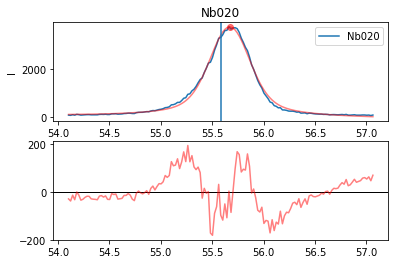

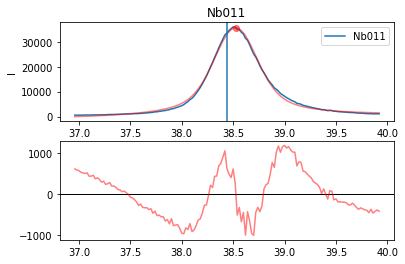

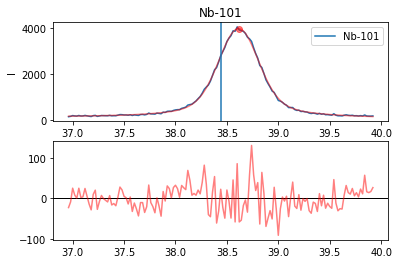

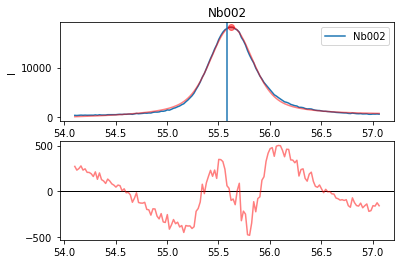

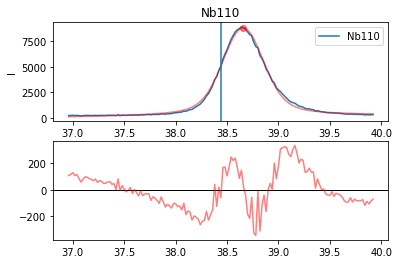

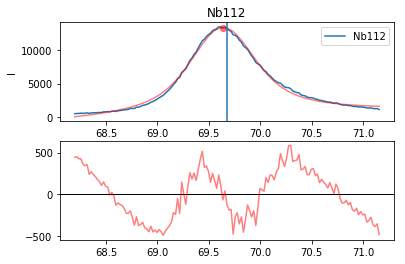

In [117]:
for m in data:
    if 'Nb' not in m.name:
        continue
    plt.figure();
    m.fit(plot=True)

## ARB16nm_sinus2psi_200Nb_phi0_psi_range120

In [141]:
def get_and_fit_data(filename, mask_function, skip_header=34):
    
    
    
    data = np.genfromtxt(filename, skip_header=skip_header, delimiter=',')

    deux_theta_span = np.unique(data[:, 0])
    psi_span = np.unique(data[:, 1])
    I = data[:, 2].reshape((len(psi_span), len(deux_theta_span)))

    #plt.plot(deux_theta_span, I.T);
    #plt.xlabel('deux theta (deg)');
    #plt.title(filename);

    mask = mask_function(deux_theta_span)
    
    fitted_pos = []
    intensites = []
    fit_errors = []
    fwhm = []
    for k, psi in enumerate(psi_span):
        #plt.plot(deux_theta_span, I[k, :], 'xk', alpha=0.2)

        deuxtheta_peak, I_peak  = deux_theta_span[mask], I[k, mask]
        x0, largeur, fitted_function = fit_peak(deuxtheta_peak, I_peak)
        sum_errors = np.sum( (fitted_function(deuxtheta_peak)-I_peak)**2 )/fitted_function(x0)
        #plt.plot(deuxtheta_peak, fitted_function(deuxtheta_peak), 'r')
        intensites.append(fitted_function(x0))
        fitted_pos.append(x0)
        fit_errors.append(sum_errors)
        fwhm.append(largeur)
        
    # Axe change
    sin2psi = np.sin(psi_span *np.pi/180)**2
    d_hkl = distance_from_Bragg(fitted_pos)
    
    return sin2psi, d_hkl, intensites, fit_errors, fwhm

In [142]:
ls {dirname}

2019_04_sinus2psi_112Nb_220Cu_psi30_phi180_10s.csv
2019_04_sinus2psi_200Nb_phi0_psi_range120.csv
2019_04_sinus2psi_Nb112_Cu220.csv
2019_05_sinus2psi_112Nb_220Cu_psi30_phi45_10s.csv
2019_05_sinus2psi_112Nb_220Cu_psi30_phi45+180_10s.csv
2019_05_sinus2psi_112Nb_220Cu_psi30_phi90_10s.csv
2019_05_sinus2psi_112Nb_220Cu_psi30_phi90+180_10s.csv


In [143]:
dirname = 'ARB_16nm/'

def mask_function_Nb(deux_theta):
    return deux_theta < 72

def mask_function_vu(deux_theta):
    return deux_theta > 72

# Load data
data = {}

# phi = 90°  -- Niobium
filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi90_10s.csv'
data['Nb_phi90_pos'] = get_and_fit_data(filename, mask_function_Nb)

filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi90+180_10s.csv'
data['Nb_phi90_neg'] = get_and_fit_data(filename, mask_function_Nb)

# phi = 90°  -- Copper
filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi90_10s.csv'
data['Cu_phi90_pos'] = get_and_fit_data(filename, mask_function_Cu)

filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi90+180_10s.csv'
data['Cu_phi90_neg'] = get_and_fit_data(filename, mask_function_Cu)


# phi = 45° -- Niobium
filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45_10s.csv'
data['Nb_phi45_pos'] = get_and_fit_data(filename, mask_function_Nb)

filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45+180_10s.csv'
data['Nb_phi45_neg'] = get_and_fit_data(filename, mask_function_Nb)

# phi = 45° -- Copper
filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45_10s.csv'
data['Cu_phi45_pos'] = get_and_fit_data(filename, mask_function_Cu)

filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45+180_10s.csv'
data['Cu_phi45_neg'] = get_and_fit_data(filename, mask_function_Cu)


# phi = 00°  -- Niobium
filename = dirname + '2019_04_sinus2psi_Nb112_Cu220.csv'
data['Nb_phi0_pos'] = get_and_fit_data(filename, mask_function_Nb, skip_header=33)

filename = dirname + '2019_04_sinus2psi_112Nb_220Cu_psi30_phi180_10s.csv'
data['Nb_phi0_neg'] = get_and_fit_data(filename, mask_function_Nb, skip_header=34)

# phi = 00°  -- Copper
filename = dirname + '2019_04_sinus2psi_Nb112_Cu220.csv'
data['Cu_phi0_pos'] = get_and_fit_data(filename, mask_function_Cu, skip_header=33)

filename = dirname + '2019_04_sinus2psi_112Nb_220Cu_psi30_phi180_10s.csv'
data['Cu_phi0_neg'] = get_and_fit_data(filename, mask_function_Cu, skip_header=34)

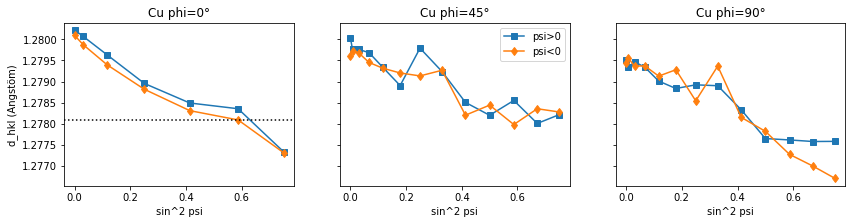

In [144]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 3));

data_pos = data['Cu_phi90_pos']
data_neg = data['Cu_phi90_neg']

axes[2].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[2].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[2].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[2].set_title('Cu phi=90°');


data_pos = data['Cu_phi45_pos']
data_neg = data['Cu_phi45_neg']

axes[1].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[1].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[1].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[1].set_title('Cu phi=45°');


data_pos = data['Cu_phi0_pos']
data_neg = data['Cu_phi0_neg']

axes[0].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[0].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[0].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[0].set_title('Cu phi=0°');


axes[0].set_ylabel('d_hkl (Angstöm)');
axes[1].legend();


a_Cu = 3.615  # Ang.
d_Cu002 = a_Cu/np.sqrt(0 + 4 + 4)
axes[0].axhline(y=d_Cu002, color='black', linestyle=':')

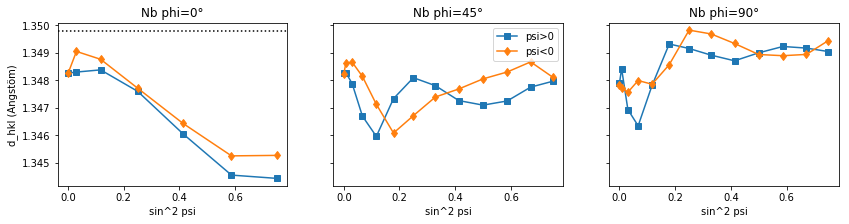

In [145]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 3));

data_pos = data['Nb_phi90_pos']
data_neg = data['Nb_phi90_neg']

axes[2].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[2].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[2].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[2].set_title('Nb phi=90°');


data_pos = data['Nb_phi45_pos']
data_neg = data['Nb_phi45_neg']

axes[1].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[1].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[1].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[1].set_title('Nb phi=45°');


data_pos = data['Nb_phi0_pos']
data_neg = data['Nb_phi0_neg']

axes[0].plot(data_pos[0], data_pos[1], label='psi>0', marker='s');
axes[0].plot(data_neg[0], data_neg[1], label='psi<0', marker='d');

axes[0].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[0].set_title('Nb phi=0°');


a_Cu = 3.615  # Ang.
a_Nb = 3.3063 # Ang.
d_Nb112 = a_Nb/np.sqrt(1 + 1 + 4)
axes[0].axhline(y=d_Nb112, color='black', linestyle=':')
axes[0].set_ylabel('d_hkl (Angstöm)');
axes[1].legend();

## Largeur

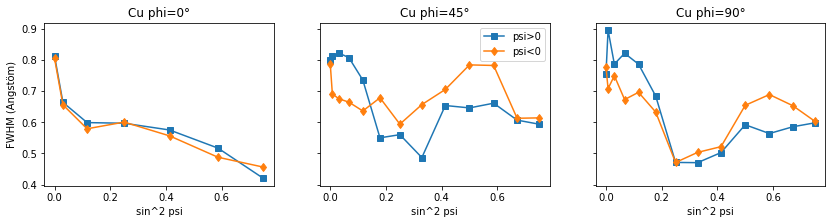

In [148]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 3));

data_pos = data['Cu_phi90_pos']
data_neg = data['Cu_phi90_neg']

axes[2].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[2].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[2].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[2].set_title('Cu phi=90°');


data_pos = data['Cu_phi45_pos']
data_neg = data['Cu_phi45_neg']

axes[1].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[1].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[1].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[1].set_title('Cu phi=45°');


data_pos = data['Cu_phi0_pos']
data_neg = data['Cu_phi0_neg']

axes[0].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[0].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[0].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[0].set_title('Cu phi=0°');


axes[0].set_ylabel('FWHM (Angstöm)');
axes[1].legend();


#a_Cu = 3.615  # Ang.
#d_Cu002 = a_Cu/np.sqrt(0 + 4 + 4)
#axes[0].axhline(y=d_Cu002, color='black', linestyle=':')

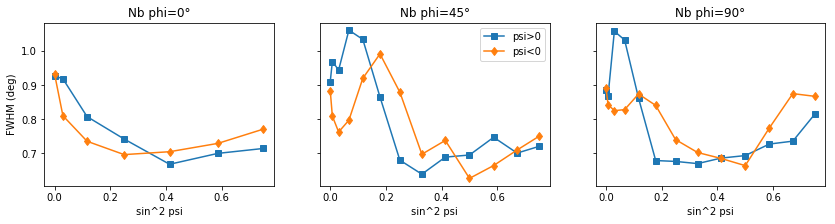

In [150]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 3));

data_pos = data['Nb_phi90_pos']
data_neg = data['Nb_phi90_neg']

axes[2].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[2].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[2].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[2].set_title('Nb phi=90°');


data_pos = data['Nb_phi45_pos']
data_neg = data['Nb_phi45_neg']

axes[1].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[1].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[1].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[1].set_title('Nb phi=45°');


data_pos = data['Nb_phi0_pos']
data_neg = data['Nb_phi0_neg']

axes[0].plot(data_pos[0], data_pos[4], label='psi>0', marker='s');
axes[0].plot(data_neg[0], data_neg[4], label='psi<0', marker='d');

axes[0].set_xlabel('sin^2 psi');# plt.ylabel('d_hkl (Angstöm)');
axes[0].set_title('Nb phi=0°');


axes[0].set_ylabel('FWHM (deg)');
axes[1].legend();


#a_Cu = 3.615  # Ang.
#d_Cu002 = a_Cu/np.sqrt(0 + 4 + 4)
#axes[0].axhline(y=d_Cu002, color='black', linestyle=':')

# Draft

In [121]:
(1.345-1.350)/1.350

-0.003703703703703789

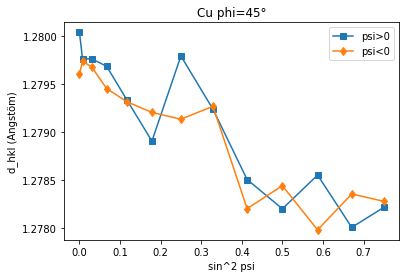

In [82]:
data_pos = data['Cu_phi45_pos']
data_neg = data['Cu_phi45_neg']

plt.plot(data_pos[0], data_pos[1], label='psi>0', marker='s')
plt.plot(data_neg[0], data_neg[1], label='psi<0', marker='d')

plt.xlabel('sin^2 psi'); plt.ylabel('d_hkl (Angstöm)');
plt.title('Cu phi=45°'); plt.legend();

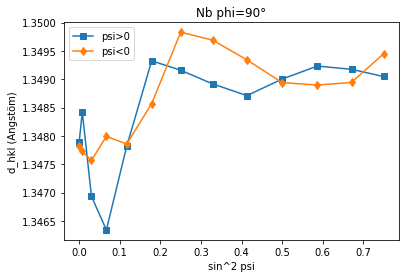

In [81]:
data_pos = data['Nb_phi90_pos']
data_neg = data['Nb_phi90_neg']

plt.plot(data_pos[0], data_pos[1], label='psi>0', marker='s')
plt.plot(data_neg[0], data_neg[1], label='psi<0', marker='d')

plt.xlabel('sin^2 psi'); plt.ylabel('d_hkl (Angstöm)');
plt.title('Nb phi=90°'); plt.legend();

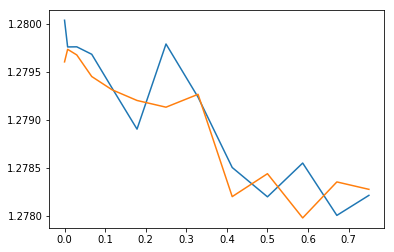

In [63]:
filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45_10s.csv'
data['Cu_phi45_pos'] = get_and_fit_data(filename, mask_function_Cu)

filename = dirname + '2019_05_sinus2psi_112Nb_220Cu_psi30_phi45+180_10s.csv'
data['Cu_phi45_neg'] = get_and_fit_data(filename, mask_function_Cu)

plt.plot(data['Cu_phi45_pos'][0], data['Cu_phi45_pos'][1])
plt.plot(data['Cu_phi45_neg'][0], data['Cu_phi45_neg'][1])

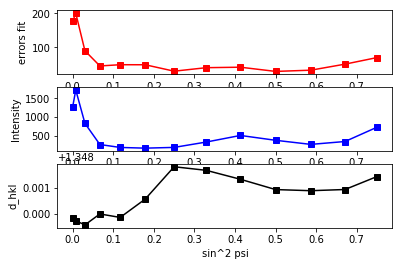

In [57]:
sin2psi, d_hkl, intensites, fit_errors = data['Nb_phi90_neg']

plt.subplot(3, 1, 1);
plt.plot(sin2psi, fit_errors, marker='s', color='red')
plt.ylabel('errors fit');

plt.subplot(3, 1, 2);
plt.plot(sin2psi, intensites, marker='s', color='blue')
plt.ylabel('Intensity');

plt.subplot(3, 1, 3);
plt.plot(sin2psi, d_hkl, marker='s', color='black')
plt.ylabel('d_hkl');

plt.xlabel('sin^2 psi');

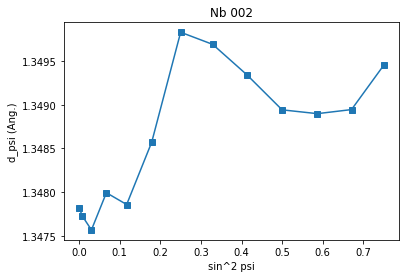

In [24]:

plt.plot(sin2psi,
         d_phipsi,
         marker='s')
plt.xlabel('sin^2 psi'); plt.ylabel('d_psi (Ang.)');
plt.title('Nb 002');

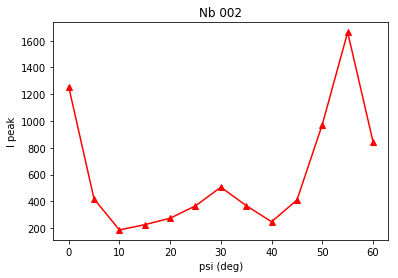

In [17]:
plt.plot(psi_span, intensites, '^-r');
plt.xlabel('psi (deg)'); plt.ylabel('I peak');
plt.title('Nb 002');

In [13]:
pente_estimation = np.ptp(d_phipsi) / np.ptp(sin2psi)
d0 = d_phipsi.max()
E, nu = 130e9, 0.35  # Pa, 1

sigma_estimation =  pente_estimation/(1+nu)*E/d0
print(f'sigma plan ~ {sigma_estimation*1e-6:0.0f} MPa')

sigma plan ~ 232 MPa


## ARB16nm_sinus2psi_Nb112_Cu220

    Cu220   74.1257°
    Nb211   69.5951°

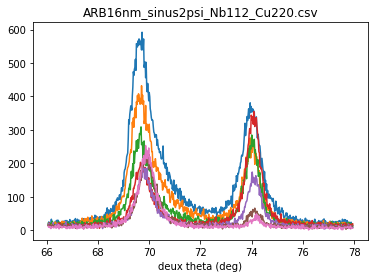

In [68]:
# Load data
filename = 'ARB16nm_sinus2psi_Nb112_Cu220.csv'
data = np.genfromtxt(filename, skip_header=33, delimiter=',')

deux_theta_span = np.unique(data[:, 0])
psi_span = np.unique(data[:, 1])
I = data[:, 2].reshape((len(psi_span), len(deux_theta_span)))

plt.plot(deux_theta_span, I.T);
plt.xlabel('deux theta (deg)');
plt.title(filename);

In [130]:
mask = deux_theta_span < 72

In [131]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,

sigma plan ~ 376 MPa


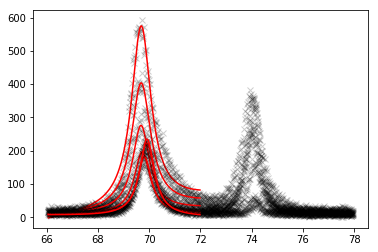

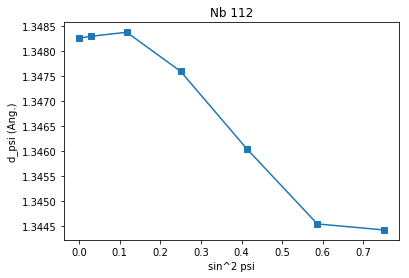

In [70]:
# Nb 112
plt.figure();
fitted_pos = []
intensites = []
for k, psi in enumerate(psi_span):
    plt.plot(deux_theta_span, I[k, :], 'xk', alpha=0.2)
    
    mask = deux_theta_span < 72
    deuxtheta_peak, I_peak  = deux_theta_span[mask], I[k, mask]
    x0, largeur, fitted_function = fit_peak(deuxtheta_peak, I_peak)
    plt.plot(deuxtheta_peak, fitted_function(deuxtheta_peak), 'r')
    intensites.append(fitted_function(x0))
    fitted_pos.append(x0)
    
# sin2 psi
sin2psi = np.sin(psi_span *np.pi/180)**2
d_phipsi = distance_from_Bragg(fitted_pos)
plt.figure();
plt.plot(sin2psi,
         d_phipsi,
         marker='s')
plt.xlabel('sin^2 psi'); plt.ylabel('d_psi (Ang.)');
plt.title('Nb 112');

# pente_estimation 
pente_estimation = np.ptp(d_phipsi) / np.ptp(sin2psi)
d0 = d_phipsi.max()
E, nu = 130e9, 0.35  # Pa, 1

sigma_estimation =  pente_estimation/(1+nu)*E/d0
print(f'sigma plan ~ {sigma_estimation*1e-6:0.0f} MPa')

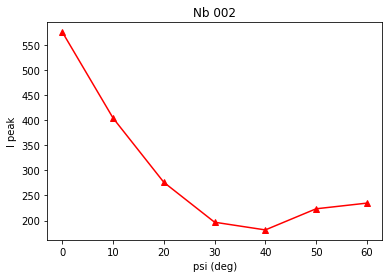

In [71]:
plt.plot(psi_span, intensites, '^-r');
plt.xlabel('psi (deg)'); plt.ylabel('I peak');
plt.title('Nb 002');

sigma plan ~ 246 MPa


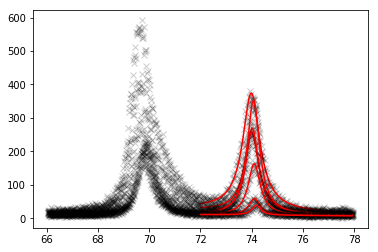

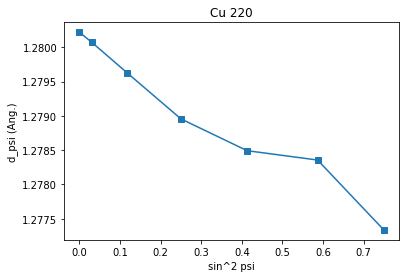

In [72]:
# Cu 220
plt.figure();
fitted_pos = []
for k, psi in enumerate(psi_span):
    plt.plot(deux_theta_span, I[k, :], 'xk', alpha=0.2)
    
    mask = deux_theta_span > 72
    deuxtheta_peak, I_peak  = deux_theta_span[mask], I[k, mask]
    x0, largeur, fitted_function = fit_peak(deuxtheta_peak, I_peak)
    plt.plot(deuxtheta_peak, fitted_function(deuxtheta_peak), 'r')
    
    fitted_pos.append(x0)
    
# sin2 psi
sin2psi = np.sin(psi_span *np.pi/180)**2
d_phipsi = distance_from_Bragg(fitted_pos)
plt.figure();
plt.plot(sin2psi,
         d_phipsi,
         marker='s')
plt.xlabel('sin^2 psi'); plt.ylabel('d_psi (Ang.)');
plt.title('Cu 220');

# pente_estimation 
pente_estimation = np.ptp(d_phipsi) / np.ptp(sin2psi)
d0 = d_phipsi.max()
E, nu = 110e9, 0.343  # Pa, 1 !!!

sigma_estimation =  pente_estimation/(1+nu)*E/d0
print(f'sigma plan ~ {sigma_estimation*1e-6:0.0f} MPa')

In [58]:
pente_estimation

0.0038449457604953596

## LaB6

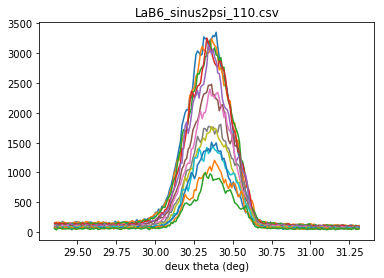

In [114]:
# Load data
filename = 'LaB6_sinus2psi_110.csv'
data = np.genfromtxt(filename, skip_header=34, delimiter=',')

deux_theta_span = np.unique(data[:, 0])
psi_span = np.unique(data[:, 1])
I = data[:, 2].reshape((len(psi_span), len(deux_theta_span)))

plt.plot(deux_theta_span, I.T);
plt.xlabel('deux theta (deg)');
plt.title(filename);

sigma plan ~ 400 MPa


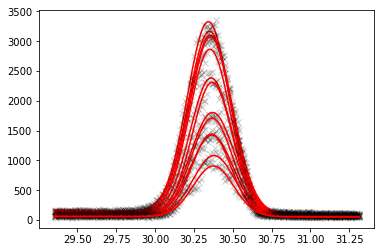

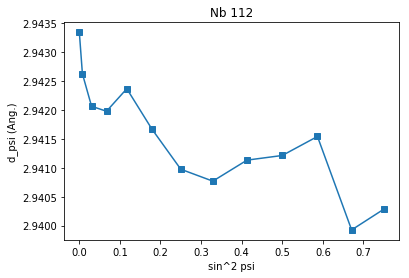

In [115]:
plt.figure();
fitted_pos = []
intensites = []
for k, psi in enumerate(psi_span):
    plt.plot(deux_theta_span, I[k, :], 'xk', alpha=0.2)
    
    mask = deux_theta_span > 0
    deuxtheta_peak, I_peak  = deux_theta_span[mask], I[k, mask]
    x0, largeur, fitted_function = fit_peak(deuxtheta_peak, I_peak, function='Gauss')
    plt.plot(deuxtheta_peak, fitted_function(deuxtheta_peak), 'r')
    intensites.append(fitted_function(x0))
    fitted_pos.append(x0)
    
# sin2 psi
sin2psi = np.sin(psi_span *np.pi/180)**2
d_phipsi = distance_from_Bragg(fitted_pos)
plt.figure();
plt.plot(sin2psi,
         d_phipsi,
         marker='s')
plt.xlabel('sin^2 psi'); plt.ylabel('d_psi (Ang.)');
plt.title('Nb 112');

# pente_estimation 
pente_estimation = np.ptp(d_phipsi) / np.ptp(sin2psi)
d0 = d_phipsi.max()
E, nu = 306e9, 0.186  # Pa, 1

sigma_estimation =  pente_estimation/(1+nu)*E/d0
print(f'sigma plan ~ {sigma_estimation*1e-6:0.0f} MPa')

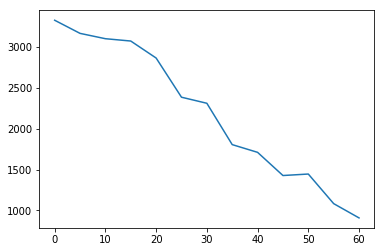

In [116]:
plt.plot(psi_span, intensites)

## PVD Si

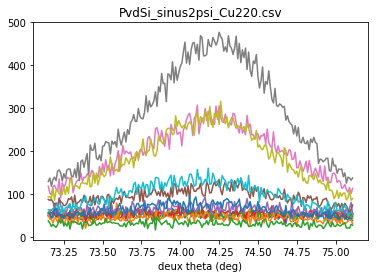

In [134]:
# Load data
filename = 'PvdSi_sinus2psi_Cu220.csv'
data = np.genfromtxt(filename, skip_header=34, delimiter=',')

deux_theta_span = np.unique(data[:, 0])
psi_span = np.unique(data[:, 1])
I = data[:, 2].reshape((len(psi_span), len(deux_theta_span)))

plt.plot(deux_theta_span, I.T);
plt.xlabel('deux theta (deg)');
plt.title(filename);

no fit
no fit
no fit
no fit
no fit


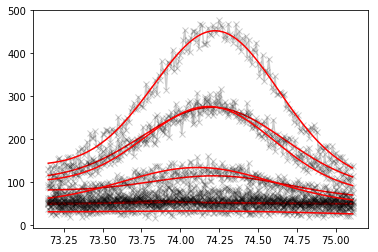

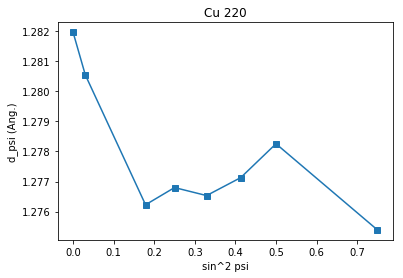

In [137]:
plt.figure();
fitted_pos, fitted_psi = [], []
intensites = []
for k, psi in enumerate(psi_span):
    plt.plot(deux_theta_span, I[k, :], '-xk', alpha=0.2)
    
    mask = deux_theta_span > 0
    deuxtheta_peak, I_peak  = deux_theta_span[mask], I[k, mask]
    try:
        x0, largeur, fitted_function = fit_peak(deuxtheta_peak, I_peak, function='Gauss')
        plt.plot(deuxtheta_peak, fitted_function(deuxtheta_peak), 'r')
        intensites.append(fitted_function(x0))
        fitted_pos.append(x0)
        fitted_psi.append(psi)
    except:
        print('no fit')
    
# sin2 psi
fitted_psi = np.array(fitted_psi)
sin2psi = np.sin(fitted_psi *np.pi/180)**2
d_phipsi = distance_from_Bragg(fitted_pos)

# sin2 psi
sin2psi = np.sin(fitted_psi *np.pi/180)**2
d_phipsi = distance_from_Bragg(fitted_pos)
plt.figure();
plt.plot(sin2psi,
         d_phipsi,
         marker='s')
plt.xlabel('sin^2 psi'); plt.ylabel('d_psi (Ang.)');
plt.title('Cu 220');

In [136]:
# pente_estimation 
pente_estimation = np.ptp(d_phipsi) / np.ptp(sin2psi)
d0 = d_phipsi.max()
E, nu = 110e9, 0.35  # Pa, 1

sigma_estimation =  pente_estimation/(1+nu)*E/d0
print(f'sigma plan ~ {sigma_estimation*1e-6:0.0f} MPa')

sigma plan ~ 557 MPa


In [4]:
1*np.pi/180 * 320

4.1887902047863905

In [12]:
import texttable as tt

In [9]:
tt.TexTable

textable.textable.TexTable

In [13]:
table = tt.Texttable()
table.set_deco(tt.Texttable.HEADER)
table.set_cols_dtype(['t',  # text
                      'f',  # float (decimal)
                      'e',  # float (exponent)
                      'i',  # integer
                      'a']) # automatic
table.set_cols_align(["l", "r", "r", "r", "l"])
table.add_rows([["text",    "float", "exp", "int", "auto"],
                ["abcd",    "67",    654,   89,    128.001],
                ["efghijk", 67.5434, .654,  89.6,  12800000000000000000000.00023],
                ["lmn",     5e-78,   5e-78, 89.4,  .000000000000128],
                ["opqrstu", .023,    5e+78, 92.,   12800000000000000000000]])
print( table.draw() )

 text     float       exp      int     auto   
abcd      67.000   6.540e+02    89   128.001  
efghijk   67.543   6.540e-01    90   1.280e+22
lmn        0.000   5.000e-78    89   0.000    
opqrstu    0.023   5.000e+78    92   1.280e+22


In [65]:
x = np.array([41.60, 41.48, 42.34, 41.95, 41.86,
              42.18, 41.72, 42.26, 41.81, 42.04])

In [70]:
x.std()/np.sqrt(len(x))

0.08523144959461872